In [54]:
import sys
!pip install pandas
import pandas as pd
import numpy as np
import nltk


import re
import nltk
from joblib import dump, load
import matplotlib.pyplot as plt
pd.options.display.max_colwidth=200
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # Asegúrate de importar StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score




import scipy.stats as stats
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold

# Metricas
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# q-q plots
import scipy.stats as stats

In [55]:
!pip install LightFM
from lightfm import LightFM
from lightfm.data import Dataset

## Carga de datos

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
pd2 = pd.read_csv('/content/drive/MyDrive/Corona/b2b_nuevo.csv' , sep=",", encoding="utf-8")

In [58]:

b2b = pd2.copy()

## Implementación B2B

In [59]:
print(b2b.columns.tolist())

['fecha_factura', 'id_b2b', 'municipio', 'zona', 'categoria_b2b_macro', 'categoria_b2b', 'subcategoria_b2b', 'producto', 'valor_total', 'alineación con portafolio estratégico b2b', 'Total de unidades', 'Total de edificaciones en obra']


In [60]:
categorical_cols = b2b.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['fecha_factura', 'id_b2b', 'municipio', 'zona', 'categoria_b2b_macro',
       'categoria_b2b', 'subcategoria_b2b', 'producto'],
      dtype='object')


### Manejo Categóricas

Fue necesario darle un manejo distinto a las variables categóricas, ya que al tener tantas categorías perjudican e imposibilitan la elaboración del modelo de recomendación

In [61]:
cat_cols = ['id_b2b', 'municipio', 'zona', 'categoria_b2b_macro',
       'categoria_b2b', 'subcategoria_b2b', 'producto']

Se utiliza la técnica de Label Encoder

In [62]:
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    b2b[f'{col}_enc'] = le.fit_transform(b2b[col].astype(str))
    label_encoders[col] = le


## Pipeline LightFM

In [63]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import numpy as np

b2b[cat_cols] = b2b[cat_cols].astype(str)

# Inicialización
dataset = Dataset()
dataset.fit(
    users=b2b['id_b2b'].unique(),
    items=b2b['producto'].unique()
)


dataset.fit_partial(
    users=b2b['id_b2b'],
    items=b2b['producto'],
    user_features=np.unique([
        *("municipio:" + b2b['municipio']),
        *("zona:" + b2b['zona']),
        *("unidades:" + b2b['Total de unidades'].astype(str)),
        *("edificaciones:" + b2b['Total de edificaciones en obra'].astype(str))
    ]),
    item_features=np.unique([
        *("cat_macro:" + b2b['categoria_b2b_macro']),
        *("cat:" + b2b['categoria_b2b']),
        *("subcat:" + b2b['subcategoria_b2b'])
    ])
)


# Interacciones
(interactions, _) = dataset.build_interactions(
    ((row['id_b2b'], row['producto'], row['valor_total']) for _, row in b2b.iterrows())
)

# User features
user_features = dataset.build_user_features(
    ((row['id_b2b'], [
        f"municipio:{row['municipio']}",
        f"zona:{row['zona']}",
        f"unidades:{row['Total de unidades']}",
        f"edificaciones:{row['Total de edificaciones en obra']}"
    ]) for _, row in b2b.iterrows())
)

# Item features
item_features = dataset.build_item_features(
    ((row['producto'], [
        f"cat_macro:{row['categoria_b2b_macro']}",
        f"cat:{row['categoria_b2b']}",
        f"subcat:{row['subcategoria_b2b']}"
    ]) for _, row in b2b.iterrows())
)

# Entrenamiento
model_lfm = LightFM(loss='warp')
model_lfm.fit(interactions,
          user_features=user_features,
          item_features=item_features,
          epochs=10,
          num_threads=4)

# Evaluación
precision = precision_at_k(model_lfm, interactions, user_features=user_features,
                           item_features=item_features, k=5).mean()
recall = recall_at_k(model_lfm, interactions, user_features=user_features,
                     item_features=item_features, k=5).mean()
auc = auc_score(model_lfm, interactions, user_features=user_features,
                item_features=item_features).mean()

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")


Precision: 0.9667
Recall: 0.0045
AUC: 0.8695


In [65]:

user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()


usuario = list(user_id_map.keys())[2]
usuario_idx = user_id_map[usuario]


n_items = len(item_id_map)


scores = model_lfm.predict(
    usuario_idx,
    np.arange(n_items),
    user_features=user_features,
    item_features=item_features
)


top_items_idx = np.argsort(-scores)


reverse_item_map = {v: k for k, v in item_id_map.items()}
top_productos = [reverse_item_map[i] for i in top_items_idx[:10]]

print(f"Recomendaciones para usuario {usuario}:\n", top_productos)


Recomendaciones para usuario B2B_03:
 ['Producto_1139', 'Producto_1053', 'Producto_552', 'Producto_553', 'Producto_1411', 'Producto_1054', 'Producto_831', 'Producto_1154', 'Producto_1361', 'Producto_801']


## Modelo Tabular

In [66]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score


b2b[cat_cols] = b2b[cat_cols].astype(str)


b2b['comprado'] = 1


clientes = b2b['id_b2b'].unique()
productos = b2b['producto'].unique()

# Generar combinaciones aleatorias de cliente-producto que NO existen en la base
neg_samples = []
existing = set(zip(b2b['id_b2b'], b2b['producto']))

np.random.seed(42)
while len(neg_samples) < len(b2b):
    c = np.random.choice(clientes)
    p = np.random.choice(productos)
    if (c, p) not in existing:
        neg_samples.append((c, p))

# Crear DataFrame con negativos
neg_df = pd.DataFrame(neg_samples, columns=['id_b2b', 'producto'])
neg_df['comprado'] = 0

# Enriquecer negativos con otras columnas usando un join por cliente y producto
cols_a_copiar = ['municipio', 'zona', 'categoria_b2b_macro', 'categoria_b2b',
                 'subcategoria_b2b', 'valor_total', 'Total de unidades', 'Total de edificaciones en obra']


for col in cols_a_copiar:
    neg_df[col] = b2b[col].sample(n=len(neg_df), replace=True).values

# Unir positivos y negativos
df_final = pd.concat([b2b[neg_df.columns], neg_df], ignore_index=True)



In [67]:
# Codificar todas las categóricas con LabelEncoder
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])
    encoders[col] = le


In [68]:
X = df_final.drop(['comprado'], axis=1)
y = df_final['comprado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100
)

model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:00:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [69]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      5174
           1       0.98      1.00      0.99      5173

    accuracy                           0.99     10347
   macro avg       0.99      0.99      0.99     10347
weighted avg       0.99      0.99      0.99     10347

AUC: 0.9993887936612383


In [70]:
def recomendar_productos(id_b2b, modelo, df_original, df_codificado, encoders, top_n=5):
    # Filtrar los productos que ya compró
    productos_comprados = df_original[df_original['id_b2b'] == id_b2b]['producto'].unique()

    # Todos los productos posibles
    todos_los_productos = df_original['producto'].unique()

    # Productos que NO ha comprado
    productos_no_comprados = [p for p in todos_los_productos if p not in productos_comprados]

    # Generar DataFrame con combinaciones del cliente con productos no comprados
    cliente_info = df_original[df_original['id_b2b'] == id_b2b].iloc[0]
    nuevas_filas = []

    for producto in productos_no_comprados:
        fila = cliente_info.copy()
        fila['producto'] = producto
        nuevas_filas.append(fila)

    pred_df = pd.DataFrame(nuevas_filas)

    # Codificar con los mismos encoders
    for col in encoders:
        pred_df[col] = encoders[col].transform(pred_df[col])

    # Hacer predicciones
    X_pred = pred_df[modelo.get_booster().feature_names]
    proba = modelo.predict_proba(X_pred)[:, 1]

    pred_df['probabilidad'] = proba

    # Decodificar producto para mostrar el nombre original
    producto_le = encoders['producto']
    pred_df['producto_nombre'] = producto_le.inverse_transform(pred_df['producto'])

    # Devolver top N recomendaciones ordenadas por probabilidad
    recomendaciones = pred_df[['producto_nombre', 'probabilidad']].sort_values(by='probabilidad', ascending=False).head(top_n)

    return recomendaciones


In [71]:
print(b2b['id_b2b'].unique())


['B2B_01' 'B2B_02' 'B2B_03' 'B2B_04' 'B2B_05' 'B2B_06']


In [72]:
recomendar_productos('B2B_01', model, b2b, df_final, encoders, top_n=10)


,producto_nombre,probabilidad
0,Producto_1437,0.992428
0,Producto_1436,0.992428
0,Producto_1439,0.992428
0,Producto_1438,0.992428
0,Producto_1447,0.992428
0,Producto_1446,0.992428
0,Producto_1443,0.992428
0,Producto_1440,0.992428
0,Producto_1441,0.992428
0,Producto_1442,0.992428


## Recomendador HIBRIDO

In [96]:
def recomendar_hibrido_b2b(cliente_id, top_n=10, alpha=0.5):
    # Validar existencia del cliente
    if cliente_id not in dataset.mapping()[0]:
        return f"Cliente {cliente_id} no está en el dataset de LightFM."

    # Productos ya comprados
    productos_comprados = set(b2b[b2b['id_b2b'] == cliente_id]['producto'].unique())
    productos_totales = b2b['producto'].unique()
    productos_candidatos = list(set(productos_totales) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    # --- LightFM ---
    usuario_interno = dataset.mapping()[0][cliente_id]
    productos_idx = [dataset.mapping()[2][p] for p in productos_candidatos if p in dataset.mapping()[2]]
    scores_lfm = model_lfm.predict(
        user_ids=np.repeat(usuario_interno, len(productos_idx)),
        item_ids=productos_idx,
        user_features=user_features,
        item_features=item_features
    )

    df_lfm = pd.DataFrame({
        'producto': [p for p in productos_candidatos if p in dataset.mapping()[2]],
        'score_lfm': scores_lfm
    })

    # --- XGBoost ---
    cliente_info = b2b[b2b['id_b2b'] == cliente_id].iloc[0]
    nuevas_filas = []

    for producto in df_lfm['producto']:
        fila = cliente_info.copy()
        fila['producto'] = producto
        nuevas_filas.append(fila)

    pred_df = pd.DataFrame(nuevas_filas)

    # Codificar con los mismos encoders usados en XGBoost
    for col in encoders:
        pred_df[col] = encoders[col].transform(pred_df[col])

    X_pred = pred_df[model.get_booster().feature_names]
    scores_xgb = model.predict_proba(X_pred)[:, 1]

    # Unir scores
    df_lfm['score_xgb'] = scores_xgb
    df_lfm['score_hibrido'] = alpha * df_lfm['score_lfm'] + (1 - alpha) * df_lfm['score_xgb']

    return df_lfm.sort_values('score_hibrido', ascending=False).head(top_n)[['producto', 'score_lfm', 'score_xgb', 'score_hibrido']]


In [97]:
recomendar_hibrido_b2b(cliente_id="B2B_01", top_n=10, alpha=0.6)


,producto,score_lfm,score_xgb,score_hibrido
1247,Producto_881,-6.922401,0.990078,-3.757410
1034,Producto_1893,-7.183212,0.991082,-3.913495
1650,Producto_884,-7.351862,0.990078,-4.015086
34,Producto_914,-7.800471,0.990078,-4.284251
96,Producto_424,-7.918420,0.990944,-4.354675
1696,Producto_394,-7.941652,0.991588,-4.368356
1143,Producto_1686,-7.969203,0.991907,-4.384759
637,Producto_286,-8.038891,0.991588,-4.426699
1020,Producto_845,-8.066646,0.990078,-4.443956
1103,Producto_1036,-8.076109,0.991867,-4.448918


## Comparación de Modelos

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

def comparar_modelos_b2b(cliente_id, top_n=30, alpha=0.5, normalizar_lfm=True):
    df_scores = recomendar_hibrido_b2b(cliente_id=cliente_id, top_n=top_n, alpha=alpha)

    if isinstance(df_scores, str):
        print(df_scores)
        return

    # --- Normalizar LightFM si se requiere ---
    if normalizar_lfm:
        min_lfm, max_lfm = df_scores['score_lfm'].min(), df_scores['score_lfm'].max()
        df_scores['score_lfm_norm'] = (df_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
        df_scores['score_hibrido_norm'] = alpha * df_scores['score_lfm_norm'] + (1 - alpha) * df_scores['score_xgb']
        cols_plot = ['score_lfm_norm', 'score_xgb', 'score_hibrido_norm']
    else:
        cols_plot = ['score_lfm', 'score_xgb', 'score_hibrido']

    # --- Estadísticas descriptivas ---
    print("Estadísticas de scores:\n")
    for col in cols_plot:
        print(f"{col}:\n{df_scores[col].describe()}\n")

    # --- Gráfico comparativo ---
    df_plot = df_scores.melt(id_vars='producto', value_vars=cols_plot,
                             var_name='modelo', value_name='score')

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Comparación de scores para Cliente {cliente_id}")
    plt.ylabel("Score")
    plt.xlabel("Producto")
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

    # --- Comparación de rankings ---
    df_scores['rank_lfm'] = df_scores['score_lfm'].rank(ascending=False)
    df_scores['rank_xgb'] = df_scores['score_xgb'].rank(ascending=False)
    df_scores['rank_diff'] = df_scores['rank_xgb'] - df_scores['rank_lfm']

    print("\nTop 5 mayores diferencias de ranking (XGBoost vs LightFM):")
    print(df_scores[['producto', 'rank_lfm', 'rank_xgb', 'rank_diff']].sort_values('rank_diff', key=abs, ascending=False).head())


Estadísticas de scores:

score_lfm_norm:
count    15.000000
mean      0.233319
std       0.316372
min       0.000000
25%       0.040967
50%       0.085814
75%       0.232744
max       1.000000
Name: score_lfm_norm, dtype: float64

score_xgb:
count    15.000000
mean      0.991047
std       0.000767
min       0.990078
25%       0.990078
50%       0.991082
75%       0.991669
max       0.991912
Name: score_xgb, dtype: float64

score_hibrido_norm:
count    15.000000
mean      0.536410
std       0.189679
min       0.396765
25%       0.421119
50%       0.448124
75%       0.535851
max       0.996031
Name: score_hibrido_norm, dtype: float64



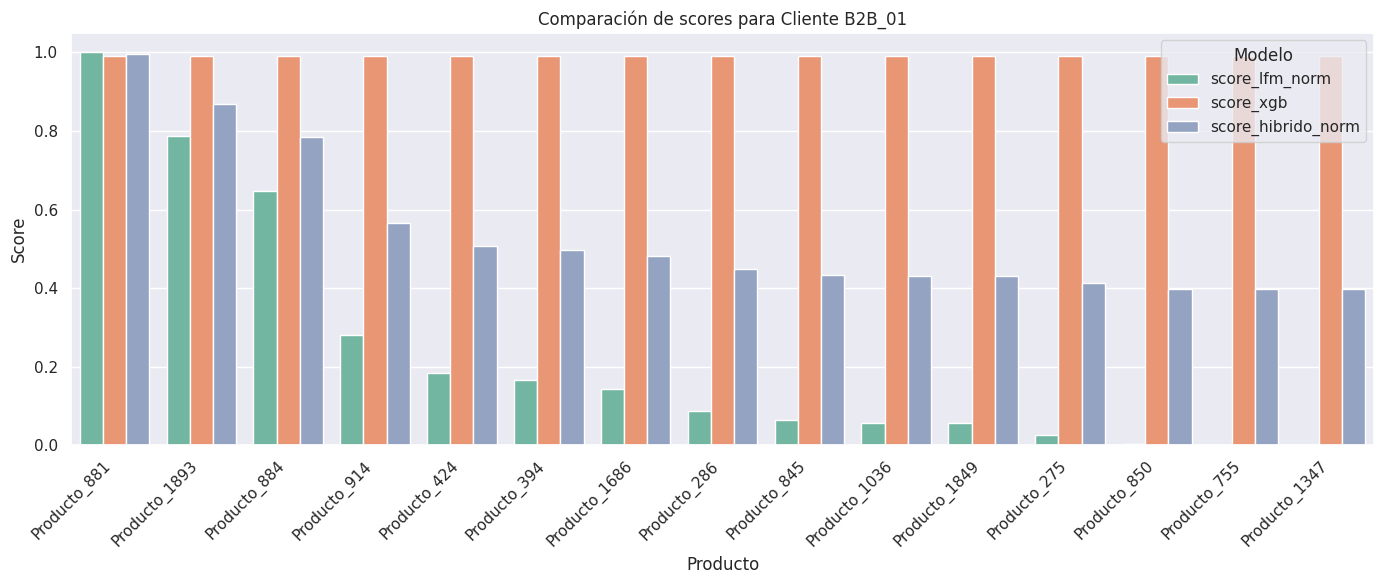


Top 5 mayores diferencias de ranking (XGBoost vs LightFM):
           producto  rank_lfm  rank_xgb  rank_diff
616   Producto_1347      15.0       1.0      -14.0
1247   Producto_881       1.0      13.0       12.0
1650   Producto_884       3.0      13.0       10.0
284    Producto_755      14.0       4.0      -10.0
34     Producto_914       4.0      13.0        9.0


In [102]:
comparar_modelos_b2b(cliente_id="B2B_01", top_n=15, alpha=0.6)

